In [2]:
from propensity_model import PropensityModel
from utils import *



# read data
file_name = f"Estimation Data - Full Model - Monopoly.dta"
# file_name = f"Estimation Data - Full Model - Split {split_no}.dta"
file_dir = "..\\data\\Full Model\\"
file_dir_name = file_dir + file_name
data = pd.read_stata(file_dir_name)
# prepare data for estmation
prepare_data(data, base_ad=50, max_ad=100)
# extract advertiser ranks
ranks_list = extract_ranks(data)


In [4]:
data['rand'] = np.random.uniform(size=len(data))

In [6]:
subsampling_ratio = 0.2
data_sub = data[data['rand'] < subsampling_ratio]

In [7]:
data_sub 

,global_token_new,impression_timestamp,event_no,publisher_subject,is_clicked,advertiser_rank,impression_repeat,impression_repeat_base_ad,previous_clicks,previous_clicks_base_ad,...,sub_10,sub_11,sub_12,sub_13,publisher_rank_sub,day,hour,mobile,ads_on_page,rand
4,363829.0,2012-09-07 00:00:00,3974878,Heath,0,1,1,0,0,0,...,0,0,0,0,8,6,4,1,6.0,0.071463
7,756484.0,2012-09-07 00:00:00,8250621,Entertainment,0,60,13,0,0,0,...,0,0,0,0,33,6,4,1,6.0,0.155667
11,756484.0,2012-09-07 00:00:00,8250621,Entertainment,0,201,1,0,0,0,...,0,0,0,0,33,6,4,1,6.0,0.075892
12,759156.0,2012-09-07 00:00:00,8280597,Movies,0,1,9,0,0,0,...,0,0,0,0,12,6,4,1,6.0,0.029844
15,759156.0,2012-09-07 00:00:00,8280597,Movies,0,7,8,0,0,0,...,0,0,0,0,12,6,4,1,6.0,0.169994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27156519,198292.0,2012-09-08 23:59:59,2171681,Heath,0,201,2,0,0,0,...,0,0,0,0,2,7,3,1,7.0,0.082414
27156526,681064.0,2012-09-08 23:59:59,7422076,Politics,0,22,4,1,0,0,...,0,1,0,0,21,7,3,1,1.0,0.072379
27156529,706750.0,2012-09-08 23:59:59,7704408,Music,0,201,8,0,0,0,...,0,0,0,0,6,7,3,1,3.0,0.039994
27156530,1175616.0,2012-09-08 23:59:59,12806552,Music,0,4,8,0,0,0,...,0,0,0,0,174,7,3,1,3.0,0.100025


In [8]:
np.random.uniform?

Docstring:
uniform(low=0.0, high=1.0, size=None)

Draw samples from a uniform distribution.

Samples are uniformly distributed over the half-open interval
``[low, high)`` (includes low, but excludes high).  In other words,
any value within the given interval is equally likely to be drawn
by `uniform`.

.. note::
    New code should use the `~numpy.random.Generator.uniform`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
low : float or array_like of floats, optional
    Lower boundary of the output interval.  All values generated will be
    greater than or equal to low.  The default value is 0.
high : float or array_like of floats
    Upper boundary of the output interval.  All values generated will be
    less than or equal to high.  The high limit may be included in the 
    returned array of floats due to floating-point rounding in the 
    equation ``low + (high-low) * random_sample()``.  The default v

In [22]:
rand = np.random.RandomState(42)

In [30]:
rand = np.random.RandomState(42)
rand.uniform(size=1)

array([0.37454012])

In [ ]:

with open("..\\results\\main_scenario\\ranks_list.pickle", "wb") as file:
    pickle.dump(ranks_list, file)

# drop rank 0 (based ad) from the list, for the base ad we don't calculate treatment effect
ranks_list.pop(0)
ranks_list.pop(-1)

(X, Y, T) = define_xyt(data.loc[0:2, :])

X_treat_indices = ['sub_1', 'sub_2', 'sub_3', 'sub_4', 'sub_5', 
               'sub_6', 'sub_7', 'sub_8','sub_9', 'sub_10', 
               'sub_11', 'sub_12', 'sub_13',
               'publisher_rank_sub', 'day', 'hour', 'mobile', 'ads_on_page']

X_treat_indices_nums = [X.columns.get_loc(col) for col in X_treat_indices if col in X.columns]


for rank in ranks_list:
    start_time_1 = time.perf_counter()
    print(f"Estimating for Rank {rank}")
    # select the subset of data for current estimation:
    df = data[(data['advertiser_rank'] == 0) | (data['advertiser_rank'] == rank)].reset_index(drop=True).copy()

    (X, Y, T) = define_xyt(df)
    # make T binary (only 0, 1)
    T = T.apply(lambda x: 0 if x == 0 else 1)


    # find best parameters for the e model
    best_params_e, best_estimator_e = e_model_best_estimator(X, T, param_grid)

    # find best parameters for the m model
    best_params_m, best_estimator_m = m_model_best_estimator(X, Y, param_grid)



    # estimate the casual forest model
    # define the causal forest model
    cf = CausalForestDML(
                            model_y=RandomForestRegressor(**best_params_m),
                            model_t=PropensityModel(**best_params_e),
                            discrete_treatment='True',
                            criterion='het',
                            n_jobs=n_jobs,
                            n_estimators=100,
                            min_samples_split=1000,
                            max_depth=20,
                            max_samples=0.01,
                            random_state=42,
                            verbose=0   
        )
    
 # tune the model:
    start_time = time.perf_counter()

    tune_params = cf.tune(
                Y=Y,
                T=T,
                X=X,
                params=cf_param_grid)
    
    finish_time = time.perf_counter()

    print(f"finished tuning the model in {finish_time - start_time} seconds")

    # fit the model using tuned parameters:
    start_time = time.perf_counter()
    
    cf.fit(Y=Y, T=T, X=X, inference="blb", cache_values=True)
    
    finish_time = time.perf_counter()
    print(f"finished fitting the model in {finish_time - start_time} seconds")

    
    # save the model
    # file_name = f"..\\results\\Full Model\\Monopoly\\CF - Rank {rank}.pkl"
    file_name = f"..\\results\\Full Model\\Split {split_no}\\CF - Rank {rank}.pkl"
    joblib.dump(cf, file_name)
    finish_time_1 = time.perf_counter()
    print(f"finished rank {rank} in {finish_time_1 - start_time_1} seconds")

In [1]:
from utils import *
import shap


# read data
file_name = "Estimation Data - Full Model - Monopoly - Whole Week.dta"
file_dir = "..\\data\\Full Model\\"
file_dir_name = file_dir + file_name
data = pd.read_stata(file_dir_name)
# keep advertiser ranks 1, 2
data = data[(data['advertiser_rank'] == 1) | (data['advertiser_rank'] == 2)]
(X, Y, T) = define_xyt(data)
# make T binary (only 0, 1)
T = T.apply(lambda x: 0 if x == 1 else 1)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
cf2 = joblib.load(f"..\\results\\Full Model\\Monopoly\\CF - Rank 1, 2 - Full Data.pkl")

In [3]:
te_ci = cf2.const_marginal_effect_interval(X[X.index % 100 == 0])
te_h = np.squeeze(te_ci[1])
te_l = np.squeeze(te_ci[0])
te = (te_h + te_l) / 2
d = {'te': te, 'te_h': te_h, 'te_l': te_l}
te_dataset=pd.DataFrame(data=d)
te_dataset = te_dataset.sort_values('te')
te_dataset = te_dataset.reset_index(drop=True)
te_dataset['pct'] = te_dataset.index / len(te_dataset) * 100

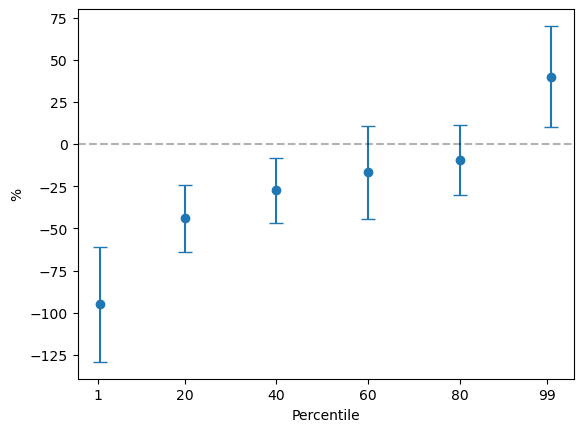

In [36]:
percentiles = np.array([1.5, 20, 40, 60,  80, 99.9])
indices = np.floor(percentiles * len(te_dataset) / 100)
te_sub = te_dataset.loc[indices, :]
ad_1_mean_ctr = data.loc[(data['advertiser_rank'] == 1), 'is_clicked'].mean() 
plt.errorbar(te_sub.pct, te_sub.te * 100 / ad_1_mean_ctr, yerr=(te_sub.te_h-te_sub.te_l) / 2 * 100 / ad_1_mean_ctr, fmt="o", capsize=5)
plt.xticks([1, 20, 40, 60, 80, 99])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Percentile')
plt.ylabel('%')
plt.savefig(f"..\\results\\Full Model\\Figures\\Treatment Effect bw Ad 1, 2.jpg", dpi=900)
plt.show()

In [38]:
summary_table = cf2.summary(decimals=6)

Population summary of CATE predictions on Training Data


In [3]:

start_time_1 = time.perf_counter()
# read data
file_name = "Estimation Data by Subject - Last Two Days Binary.dta"
file_dir = "..\\data\\"
file_dir_name = file_dir + file_name
data = pd.read_stata(file_dir_name)


# only keep the base ad
data = data[data['advertiser_rank'] == base_ad]

# Define X variables (Note that I am not using previous_clicks and i mpression_repeat variables here, because I'm only using base ad repeats and clicks here)
X = data[['previous_clicks_all_ads',
    'impression_repeat_base_ad', 'previous_clicks_base_ad', 'total_visits',
    'visit_s1', 'visit_s2', 'visit_s3', 'visit_s4', 'visit_s5', 'visit_s6',
    'visit_s7', 'visit_s8', 'visit_s9', 'visit_s10', 'visit_s11',
    'visit_s12', 'visit_s13', 'visit_s14', 'visit_s15', 'visit_s16',
    'visit_s17', 'visit_s18', 'visit_s19', 'visit_s20', 'visit_s21',
    'visit_s22', 'visit_s23', 'visit_s24', 'visit_s25', 'visit_s26',
    'sub_1', 'sub_2', 'sub_3', 'sub_4', 'sub_5', 'sub_6', 'sub_7', 'sub_8',
    'sub_9', 'sub_10', 'sub_11', 'sub_12', 'sub_13', 'sub_14', 'sub_15',
    'sub_16', 'sub_17', 'sub_18', 'sub_19', 'sub_20', 'sub_21', 'sub_22',
    'sub_23', 'sub_24', 'sub_25', 'sub_26', 'mobile']]

Y = data['is_clicked']



In [5]:

# Define the hyperparameters to search over
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [1000 , 2000, 3000, 5000]
}


start_time = time.perf_counter()
y0_model = RandomForestRegressor(verbose=0, n_jobs=30)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=y0_model, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(X, Y)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
finish_time = time.perf_counter()
print(f"finished tuning the y0 model in {finish_time - start_time} seconds")

base_ad_y_model = best_estimator

# save the model
file_name = f"..\\results\\main_scenario\\base_ad_y_model.pkl"
joblib.dump(base_ad_y_model, file_name)
finish_time_1 = time.perf_counter()
print(f"finished in {finish_time_1 - start_time_1} seconds")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
finished tuning the y0 model in 1200.4566747 seconds
finished in 1429.5135788 seconds
